In [26]:
from __future__ import annotations
import json, re
from pathlib import Path
from typing import List, Tuple
import pandas as pd

# ─────────── Locate project root ────────────
PROJECT_ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
OUTPUT_DIR   = PROJECT_ROOT / "outputs"
TABLE_DIR    = PROJECT_ROOT / "tables"
CSV_OUT      = TABLE_DIR / "press_results_f1.csv"

RAW_BENCHMARKS = ["gsm8k", "math", "olympiadbench", "omnimath"]
BENCH_DISPLAY  = {
    "gsm8k": "GSM8K",
    "math": "MATH",
    "olympiadbench": "Olympiad-Bench",
    "omnimath": "Omni-MATH",
}
RUN_RE = re.compile(r"_(?P<press>[^_]+)_r(?P<ratio>[0-9]*\.?[0-9]+)_q", re.IGNORECASE)

# ───────────────── Helpers ──────────────────
def extract_press_ratio(dirname: str) -> Tuple[str, float]:
    m = RUN_RE.search(dirname)
    if not m:
        raise ValueError(f"Not a run folder: {dirname}")
    return m.group("press"), float(m.group("ratio"))

def load_f1(path: Path):
    if not path.is_file():
        return None
    try:
        with path.open() as f:
            return json.load(f).get("f1")
    except Exception as exc:
        print(f"⚠️  Skipping {path} ({exc})")
        return None

# ─────────── Gather & build table ───────────
def gather_rows() -> List[dict]:
    rows = []
    if not OUTPUT_DIR.exists():
        raise SystemExit(f"outputs/ directory not found at {OUTPUT_DIR}")

    for run_dir in OUTPUT_DIR.iterdir():
        if not run_dir.is_dir():
            continue
        try:
            press, ratio = extract_press_ratio(run_dir.name)
        except ValueError:
            continue  # unrelated folder
        row = {"Press": press, "Ratio": ratio}
        for bm in RAW_BENCHMARKS:
            row[bm] = load_f1(run_dir / f"{bm}_summary.json")
        rows.append(row)
    return rows

def build_table(rows: List[dict]) -> pd.DataFrame:
    df = pd.DataFrame(rows)

    # Round F‑1s
    for bm in RAW_BENCHMARKS:
        df[bm] = df[bm].apply(lambda x: round(x, 1) if isinstance(x, (int, float)) else x)

    # Compute Average when all four scores present
    df["Average"] = df[RAW_BENCHMARKS].apply(lambda r: round(r.mean(), 1) if r.notna().all() else pd.NA, axis=1)

    # Sort: baseline first
    baseline = (df["Press"] == "None") & (df["Ratio"] == 0.0)
    df = pd.concat([df[baseline], df[~baseline].sort_values(["Press", "Ratio"])],
                   ignore_index=True)

    # Rename columns for display/CSV
    df.rename(columns=BENCH_DISPLAY, inplace=True)
    return df

# ─────────────────── Main ───────────────────
def main():
    rows = gather_rows()
    if not rows:
        print("No run folders found - nothing to do.")
        return

    table = build_table(rows)

    TABLE_DIR.mkdir(exist_ok=True, parents=True)
    table.to_csv(CSV_OUT, index=False, float_format="%.2f", na_rep="")

    # Console display tweaks
    display_table        = table.copy()
    display_table["Ratio"] = display_table["Ratio"].apply(lambda r: f"{r*100:.0f}%")

    # turn all missing values into empty strings for clean printing
    display_table = display_table.astype(object).where(display_table.notna(), "")

    print("=== F1 Table Summary ===")
    print(display_table.to_string(index=False, na_rep=""))
    print(f"\nCSV saved to {CSV_OUT.relative_to(PROJECT_ROOT)}")

if __name__ == "__main__":
    main()


=== F1 Table Summary ===
                 Press Ratio GSM8K  MATH Olympiad-Bench Omni-MATH Average
                  None    0%  45.0  36.9           30.6      28.9    35.4
         ComposedPress   10%  45.3  37.3           31.6      28.9    35.8
         ComposedPress   25%  45.3  34.7           31.2      29.8    35.2
         ComposedPress   50%  43.3  33.1           31.2      31.6    34.8
         ComposedPress   70%  25.8  24.3           24.1      24.5    24.7
         ComposedPress   90%  15.9  20.4            5.8       9.3    12.8
         ComposedPress   95%   0.0  10.9           15.6      13.8    10.1
ExpectedAttentionPress   10%  47.1  38.2           32.4      30.9    37.2
ExpectedAttentionPress   25%  46.0  37.0           33.1      32.3    37.1
ExpectedAttentionPress   50%  39.0  29.2           29.0      28.1    31.3
ExpectedAttentionPress   70%  33.2  26.0           21.1      20.9    25.3
ExpectedAttentionPress   90%  23.5  17.9           16.2      12.4    17.5
ExpectedAtten

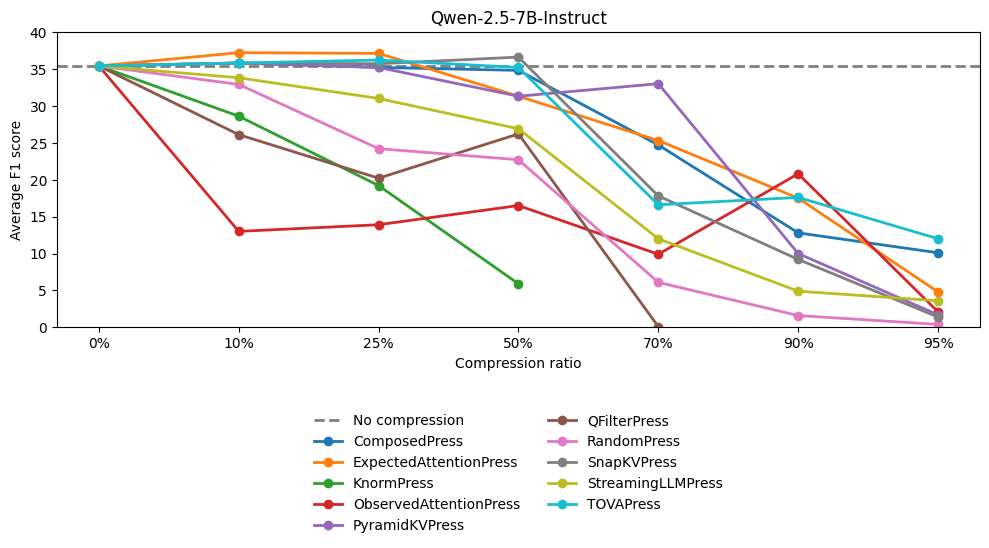

In [37]:
#!/usr/bin/env python3
"""
plot_kvpress_avg.py  –  v3
"""

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH    = Path("tables/press_results_f1.csv")
MODEL_NAME  = "Qwen-2.5-7B-Instruct"
BASELINE_F1 = 35.4
RATIOS      = ["0%", "10%", "25%", "50%", "70%", "90%", "95%"]
COLORS      = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# ─── Load & reshape ─────────────────────────────────────────────────────────
df = pd.read_csv(CSV_PATH)
df["RatioStr"] = (df["Ratio"] * 100).round(0).astype(int).astype(str) + "%"

pivot = (
    df.pivot_table(index="Press", columns="RatioStr", values="Average", aggfunc="first")
      .reindex(columns=RATIOS)
      .dropna(how="all")
)

# ─── Plot ────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))

# Baseline (dashed grey)
ax.axhline(BASELINE_F1, color="grey", linewidth=2,
           linestyle="--", label="No compression")

# Curves
color_idx = 0
for tech, row in pivot.drop("None", errors="ignore").iterrows():
    y_vals = [BASELINE_F1] + row[RATIOS[1:]].tolist()
    x_vals = list(range(len(RATIOS)))
    ax.plot(x_vals, y_vals, marker="o", linewidth=2,
            label=tech, color=COLORS[color_idx % len(COLORS)])
    color_idx += 1

# Aesthetics
ax.set_xticks(range(len(RATIOS)))
ax.set_xticklabels(RATIOS)
ax.set_xlabel("Compression ratio")
ax.set_ylabel("Average F1 score")
ax.set_title(MODEL_NAME)
ax.set_ylim(0, 40)

# Legend below plot
ax.legend(bbox_to_anchor=(0.5, -0.25), loc="upper center",
          ncol=2, frameon=False)

fig.tight_layout()
plt.show()
